# Actrivity 2.2. Regularisation
Last modified (14 Aug 2023)

### Learning Outcomes

In this activity we learn how to

- running and evaluating ridge and lasso regression using `scikit-learn`
- investigate the fitted weight vectors of linear models
- to use lasso regression for feature selection
- to relate the regularisation parameter to model complexity, overfitting, and underfitting

### Prerequisites

- Lecture 3
- Activity 2.1

## Introduction

In the lecture we have introduced the idea of regularised least squares regression. That means that instead of fitting the weight by minimising the mean squared error
\begin{equation*}
E(\mathbf{w}) = \frac{1}{2N} \sum_{n=1}^N (t_i - y(\mathbf{x}_i, \mathbf{w}))^2
\end{equation*}
we can minimise the weighted sum of the error and (squared) norm of the weight vector. In particular, we looked at the two variants
\begin{align*}
E^{(L_2)}_\lambda(\mathbf{w}) &= E(\mathbf{w}) + \lambda \|\mathbf{w}\|_2^2\\
E^{(L_1)}_\lambda(\mathbf{w}) &= E(\mathbf{w}) + \lambda \|\mathbf{w}\|_1
\end{align*}
where the first is known as **ridge regression** and the second is known as **lasso regression** where $\lambda$ is known as the **regularisation parameter**. Here, we will test and evaluate these methods on a real-world regression task.

Note that we will not implement the fitting algorithms here but instead use the implementation from `scikit-learn`. In Assignment 1 you will work on fitting a ridge regression model.

## Dataset

In this activity we work with another popular real-world dataset that is often used as an example regression problem: the [diabetes](https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset) dataset, which is also available through `scikit-learn`. The task associated with this dataset is to determine the progression of the diabetes disease (measured quantitively as a real number) in a patient based on observed blood markers and other physiological measurements.

**Note: When we load the dataset with the default parameters of the `load_diabetes` function, all input variables are standardised, which is very important when applying regularised regression methods. In the future, when working with other datasets you have to transform the data yourself to be standardised (in the next activity we will look at transformations).**

In [1]:
from sklearn.datasets import load_diabetes

diabetes = load_diabetes()
diabetes.feature_names, diabetes.data.shape

(['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6'], (442, 10))

Let us check that the data is indeed already normalised such that columns all have a standard deviation of $\sqrt{N}$.

In [2]:
diabetes.data.std(axis=0)*len(diabetes.data)**0.5

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In contrast, the target variable is not normalised, but this is not critical for our regularisation, as it affects all weights equally.

In [3]:
diabetes.target.std()*len(diabetes.data)**0.5

1618.953095192813

## Model Fitting and Basic Evaluation

#### Task A: Fit models

**Complete the code to perform the following tasks:**

- **Split the diabetes data and target into train and test portion using 80% of the data as training.** Hint: we have implemented a function for data splitting in Activity 1.1. Conveniently, the same function is available as `sklearn.model_selection.train_test_split`. Use a fixed random seed so that your results are deterministic and, hence, your analysis will be consistent with the generated images.

- **Fit an ordinary least squares (linear) model, a ridge regression, and a lasso regression model to the training data. For the two regularised variants use a regularisation parameter value of $0.1$.** Note: We are not implementing fitting algorithms here, but instead simple use the estimators provided in `sklearn.linear_model`, namely `LinearRegression`, [`Ridge`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html), and [`Lasso`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html).

In [4]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(diabetes.data, diabetes.target, shuffle=True, train_size=0.8, random_state=0)

linear = LinearRegression().fit(x_train, y_train)
ridge = Ridge(alpha=0.1).fit(x_train, y_train)
lasso = Lasso(alpha=0.1).fit(x_train, y_train)

#### Task B: Formulate and test your expectations

**Briefly formulate your expectation about the following questions and then test your hypotheses by computing the corresponding quantities. How will the three models rank in terms of:** 

- train mean squared error
- test mean squared error
- Euclidean (L2) norm of fitted coefficients 
- Manhatten (L1) norm of fitted coefficients

Hints:

- You can implement the mean squared error computation from hand (using numpy or plain Python) or simply import the corresponding metric from [`sklearn.metrics`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics)
- Similar, you can compute the coefficient norms with your own plain Python or numpy function or use [`numpy.linalg.norm`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html) (the ord parameter can be used to determine what norm is computed).
- Remember that the coeffficents of the fitted linear models can be accessed via `coef_` (where the trailing underscore indicated that the attribute is only available after fitting).

*The train error of the regularised variants will be higher than that for ordinary least squares, because the regularised objectives compromise the train error with the regularisation term. In contrast, for the test error there is the possibility that the regularised variants are better than ordinary least squares, assuming that the regularisation parameter has been set appropriately. Correspondingly, the norms of the weights will be highest for the ordindary least squares fit because that does not minimise any norm. Further, according to the objective functions, the L2-norm will be smallest for the ridge weights, whereas the L1-norm will be smallest for the lasso weights.*

In [6]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_train, linear.predict(x_train)), mean_squared_error(y_train, ridge.predict(x_train)), mean_squared_error(y_train, lasso.predict(x_train))

(2734.7508990757424, 2768.2301421988927, 2782.4165053337683)

In [6]:
mean_squared_error(y_test, linear.predict(x_test)), mean_squared_error(y_test, ridge.predict(x_test)), mean_squared_error(y_test, lasso.predict(x_test))

(3424.316688213733, 3372.649627810032, 3383.5512093461225)

In [7]:
from numpy.linalg import norm

norm(linear.coef_), norm(ridge.coef_), norm(lasso.coef_)

(1257.5595956615068, 826.0347075901203, 861.8327916314057)

In [8]:
norm(linear.coef_, 1), norm(ridge.coef_, 1), norm(lasso.coef_, 1)

(3103.5935787822973, 2069.4046503456175, 1833.9319930134868)

## Lasso for Feature Selection

As mentioned in the lecture, the L1-regularisation employed by lasso will, given suitable choices of $\lambda$, lead to sparse weight vectors, i.e., weight vectors where a subset of the weights are $0$. This is in contrast to the L2-regularisation employed by ridge regression.

This can be interpreted as a variable/feature selection procedure where the lasso selects (deems relevant) variables that have a non-zero weight and deselects (deems irrelevant) those that have a zero weight.

#### Task C: Determine Lasso Feature Selection

**Compile lists of the names of the features that lasso has selected as relevant and irrelevant, respectively**

In [9]:
[diabetes.feature_names[j] for j in range(len(diabetes.feature_names)) if abs(lasso.coef_[j])>0]

['sex', 'bmi', 'bp', 's1', 's3', 's5', 's6']

In [10]:
[diabetes.feature_names[j] for j in range(len(diabetes.feature_names)) if lasso.coef_[j]==0]

['age', 's2', 's4']

## Effect of Regularisation Parameter Value

After having investigated the regularised models for a single value of the regularisation parameter (0.1), let us finally see how the model fits will evolve when changing that value. In fact, when using these models, you would always check a wide range of different $\lambda$-values as it is a priori unclear even what order of magnitude will lead to a good fit.

Therefore one typically tries an exponentially spaced grid of candidate values which can be generated with [`numpy.logspace`](https://numpy.org/doc/stable/reference/generated/numpy.logspace.html).

In [11]:
import numpy as np

alphas = np.logspace(-4, 2.0, 200)
ridges = [Ridge(alpha=alpha) for alpha in alphas]
lassos = [Lasso(alpha=alpha) for alpha in alphas]

for i in range(len(alphas)):
    ridges[i].fit(x_train, y_train)
    lassos[i].fit(x_train, y_train)

ridge_test_errors = [mean_squared_error(y_test, ridge.predict(x_test)) for ridge in ridges]
lasso_test_errors = [mean_squared_error(y_test, lasso.predict(x_test)) for lasso in lassos]
ridge_train_errors = [mean_squared_error(y_train, ridge.predict(x_train)) for ridge in ridges]
lasso_train_errors = [mean_squared_error(y_train, lasso.predict(x_train)) for lasso in lassos]

Let us plot the corresponding train and test errors as well as weight evolution.

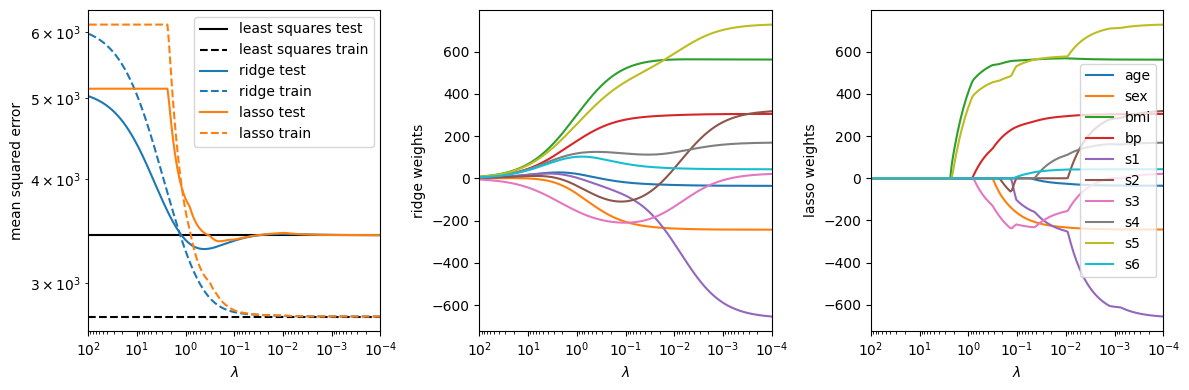

In [12]:
from matplotlib import pyplot as plt

_, axs = plt.subplots(1, 3, figsize=(12, 4), tight_layout=True)
axs[0].axhline(mean_squared_error(linear.predict(x_test), y_test), label='least squares test', color='black', linestyle='-')
axs[0].axhline(mean_squared_error(linear.predict(x_train), y_train), label='least squares train', color='black', linestyle='--')
lines = axs[0].plot(alphas, ridge_test_errors, label='ridge test')
axs[0].plot(alphas, ridge_train_errors, linestyle='--', color=lines[0].get_color(), label='ridge train')
lines = axs[0].plot(alphas, lasso_test_errors, label='lasso test')
axs[0].plot(alphas, lasso_train_errors, linestyle='--', color=lines[0].get_color(), label='lasso train')
axs[0].set_yscale('log')
axs[0].set_xscale('log')
axs[0].legend()
axs[0].set_ylabel('mean squared error')
for j in range(len(linear.coef_)):
    axs[1].plot(alphas, [ridge.coef_[j] for ridge in ridges], label=diabetes.feature_names[j])
axs[1].set_xscale('log')
axs[1].set_ylabel('ridge weights')
for j in range(len(diabetes.feature_names)):
    axs[2].plot(alphas, [lasso.coef_[j] for lasso in lassos], label=diabetes.feature_names[j])
axs[2].set_xscale('log')
axs[2].legend()
axs[2].set_ylabel('lasso weights')
for j in range(3):
    axs[j].set_xlabel('$\lambda$')
    axs[j].invert_xaxis()
    axs[j].margins(x=0)
plt.show()

## Discussion

#### Task D: Analyse the figure generated above

**Answer the following questions:**

- **Can you relate the different $\lambda$-values to the concept of underfitting and overfitting?**

- **Based on the one train/test split that we have performed, what seems to be the best model?**

- **Is there something to note about the sign of the weights and the magnitude of the weights as $\lambda$ decreases? What does this imply when we want to interpret the weights as direction and magnitude of effect that a variable has on the target?**

*For large values of $\lambda$, the regularised errors are higher than that of the least squares fit and the train errors are higher than the test errors. In this range, the regularised models are very stiff as indicated by the small weight magnitudes (even all zero for lasso). This can be regarded as underfitting. Then the errors rapidly decline to a level below that of the least squares fit. In this range, the train errors become slighlty lower than the test errors and we achieve the overall best fit by the ridge model with lambda values between 1 and 0.1. Finally, the train and test error converge to those of the least squares fit for very small lambda values. In this range the test error is much larger than the train error. Hence, the models can be regarded as overfitting here.*

### Further optional activities

As final questions and suggestion for study according to your own curiosity:

- What is the risk with the conclusions above? 
- How could we increase the reliability of our model assessment?